# Tripartite with excitatory STDP

On the excitatory synapses

In [45]:
from brian2 import *
%matplotlib inline

In [46]:
# Constants
tau = 30*ms
I = 1.1/ms
gamma = 1/ms

# Non-dimensionalized constants
tp = tau/ms
curr = I*ms
g = gamma*ms
out = curr/g  #should be > the threshold of firing

# equation (1)
eqs = '''
dv/dt = I - gamma*v : 1
'''

# equation (2) 
eqs2 = '''
dv/dt = ((I/gamma) - v)/tau : 1
'''

In [47]:
start_scope()

n_i = 90 # 3 groups of n_i/3
n_e = 60

seed(21)

G1 = NeuronGroup(n_i, eqs2, threshold='v>1', reset='v = 0', method='exact')
G2 = NeuronGroup(n_e, eqs2, threshold='v>1', reset='v = 0', method='exact')

group1init = randint(0, 10, size=n_i)/10
group2init = randint(0, 10, size=n_e)/10

G1.v = group1init
G2.v = group2init

In [48]:
matrix = zeros((n_i, n_i))

def matcon(i,j):
        matrix[i, j] = 1

# each group of 30 to everything else
for i in range(n_i//3):
        for j in range(n_i//3, n_i):
                matcon(i,j)
for i in range(n_i//3, 2*n_i//3):
        for j in range(2*n_i//3, n_i):
                matcon(i,j)
        for j in range(0, n_i//3):
                matcon(i,j)
for i in range(2*n_i//3, n_i):
        for j in range(0, 2*n_i//3):
                matcon(i,j)

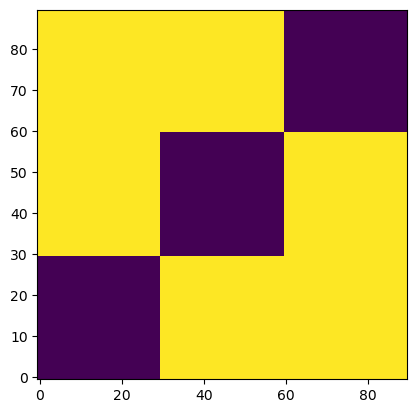

In [49]:
imshow(matrix, origin='lower');

In [50]:
inh = 0.005
exc = 0.005

p = 0.6
exc_matrix = choice(2, (n_e, n_i), p=[1-p, p])

si, ti = matrix.nonzero()
se, te = exc_matrix.nonzero()

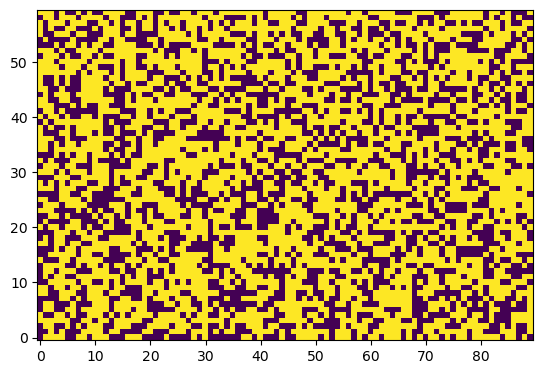

In [51]:
imshow(exc_matrix, origin='lower');

In [52]:
tau_stdp = 200*ms
# gmax = .01
# dApre = .01
# dApost = -dApre * taupre / taupost * 1.05
# dApost *= gmax
# dApre *= gmax

gmax = 1.0

# I1 = Synapses(G1, G1,
#               '''w : 1
#               dApre/dt = -Apre/tau_stdp : 1 (event-driven)
#               dApost/dt = -Apost/tau_stdp : 1 (event-driven)
#               ''',
#               on_pre='''Apre += 0.4
#               w = clip(w + Apost, 0, gmax)
#               v = out * (1-exp(-(tp * log(1/(1 - g*(v_post - inh*w)/curr)))/tp))''',
#               on_post='''Apost -= 0.4
#               w = clip(w + Apre, 0, gmax)
#               ''')

I1 = Synapses(G1, G1, on_pre='v = out * (1-exp(-(tp * log(1/(1 - g*(v_post - inh)/curr)))/tp))')

# Excitatory synapses
E1 = Synapses(G2, G1,
              '''w : 1
              dApre/dt = -Apre/tau_stdp : 1 (event-driven)
              dApost/dt = -Apost/tau_stdp : 1 (event-driven)
              ''',
              on_pre='''Apre += 0.4
              w = clip(w + Apost, 0, gmax)
              v = out * (1-exp(-(tp * log(1/(1 - g*(v_post + exc*w)/curr)))/tp))''',
              on_post='''Apost -= 0.4
              w = clip(w + Apre, 0, gmax)
              ''')

I1.connect(i=si, j=ti)

E1.connect(i=se, j=te)

M1 = StateMonitor(G1, 'v', record=True)
Sp1 = SpikeMonitor(G1)
Wmon = StateMonitor(E1, 'w', record=True)
E1.w = 'rand() * gmax'

In [53]:
run(3000*ms)

WARNING    Came across an abstract code block that may not be well-defined: the outcome may depend on the order of execution. You can ignore this warning if you are sure that the order of operations does not matter. 8 lines of abstract code, first line is: '_Apost := Apost * exp(_lio_1 * (- (t - lastupdate))) (constant)'
 [brian2.codegen.generators.base]


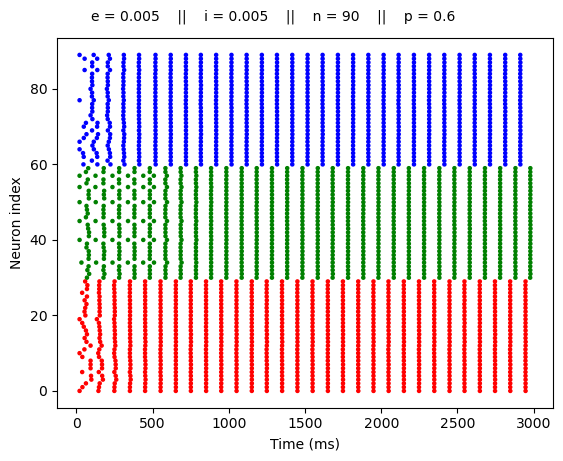

In [68]:
from matplotlib.colors import ListedColormap
copy =  Sp1.i
labels = zeros(len(copy))

for i in range(len(copy)):
        if copy[i]<30:
                labels[i] = 0
        if copy[i]>=30 and copy[i]<60:
                labels[i] = 1
        elif copy[i]>=60 and copy[i]<90:
                labels[i] = 2
colors = ['red','green','blue'] # [0, 1, 2]

scatter(Sp1.t/ms, Sp1.i, s=5, c=labels, cmap=ListedColormap(colors))
xlabel('Time (ms)')
ylabel('Neuron index')
text(98, 98, 'e = {}    ||    i = {}    ||    n_i = {}    ||    p = {}'.format(exc, inh, n_i, p))
show()

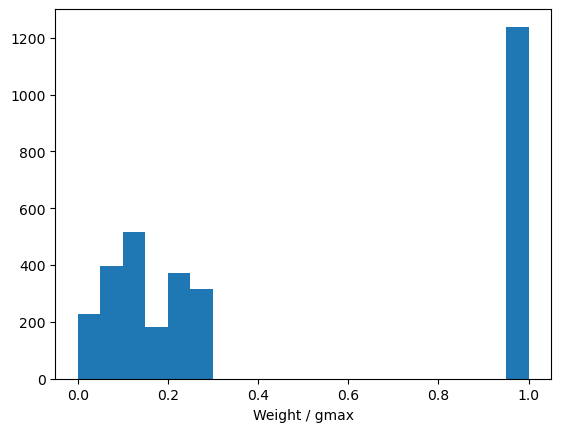

In [67]:
hist(Wmon.w[:,29000], 20)
xlabel('Weight / gmax');